In [1]:
#import libs
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from matplotlib import colors
from matplotlib import ticker
from matplotlib import rcParams
from matplotlib import patches
import xarray as xr
import scipy.io
import astropy.constants as const
rcParams['text.usetex'] = True
rcParams['font.family'] = 'serif'
import pandas as pd
import fitting_template
import importlib
#from IPython.display import display, Math
from astropy.modeling import models, fitting, Fittable1DModel, Parameter
from scipy.optimize import curve_fit
importlib.reload(fitting_template)
import fitting_template
from fitting_template import FeXII_fit
from fitting_template import myGaussian1D
#import emcee
#import george
#from george import kernels
#from multiprocessing import Pool

In [2]:
c = const.c.cgs.value
amu = const.u.cgs.value
k_B = const.k_B.cgs.value
hplanck = const.h.cgs.value

In [12]:
#read dataset
data_set_limb = scipy.io.readsav('../save/new_lvl1_offset_limb_retain.sav',verbose = True,python_dict=True)
data_set_disk = scipy.io.readsav('../save/new_lvl1_offset_disk_retain.sav',verbose = True,python_dict=True)

--------------------------------------------------
Date: Tue Jun 30 07:08:40 2020
User: yjzhu
Host: Yingjies-MacBook-Pro.local
--------------------------------------------------
Format: 11
Architecture: x86_64
Operating System: darwin
IDL Version: 8.2
--------------------------------------------------
Successfully read 5 records of which:
 - 1 are of type TIMESTAMP
 - 1 are of type VERSION
 - 2 are of type VARIABLE
--------------------------------------------------
Available variables:
 - wvl [<class 'numpy.ndarray'>]
 - new_data_offset [<class 'numpy.ndarray'>]
--------------------------------------------------
--------------------------------------------------
Date: Tue Jun 30 07:10:05 2020
User: yjzhu
Host: Yingjies-MacBook-Pro.local
--------------------------------------------------
Format: 11
Architecture: x86_64
Operating System: darwin
IDL Version: 8.2
--------------------------------------------------
Successfully read 5 records of which:
 - 1 are of type TIMESTAMP
 - 1 are of 

In [28]:
#correct slit tilt
def correct_tilt(wvl_old,data_input):
    data_2d = data_input.copy()
    #c1 = 0.0002037
    #c2 = -4.6065e-8
    c1 = 0.1415e-3
    c2 = -0.0205e-6
    
    for ii in range(512):
        #wvl_cor = c1*(ii+512) + c2*((ii+512)**2) - c1*512. - c2*512.**2
        wvl_cor = c1*ii + c2*np.square(ii)
        data_2d[ii,:] = np.interp(wvl_old, wvl_old - wvl_cor,data_2d[ii,:])
        
    return data_2d

#A function to average every N rows...
def avg(myArray, N=2):
    cum = np.cumsum(myArray,0)
    result = cum[N-1::N]/float(N)
    result[1:] = result[1:] - result[:-1]
    return result

/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: RuntimeWarning: divide by zero encountered in log10
  
/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in log10
  


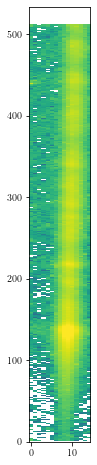

In [17]:
fig, ax = plt.subplots(figsize = (16,8))
ax.imshow(np.log10(data_set_disk['new_data_offset'][2,:,835:850]),origin = 'lower',aspect = 0.2,vmin=-2,vmax=3)

In [26]:
lvl1_data = data_set_disk['new_data_offset'][2,:,835:850]
%store lvl1_data

Stored 'lvl1_data' (ndarray)


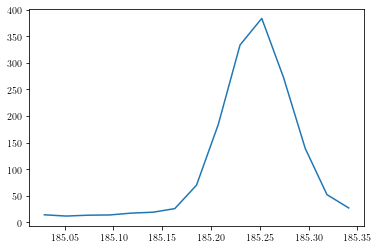

In [31]:
plt.plot(data_set_disk['wvl'][835:850],np.mean(data_set_disk['new_data_offset'][2,300:320,835:850],axis=0))

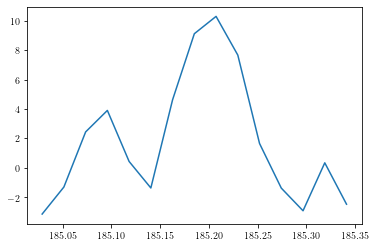

In [25]:
plt.plot(data_set_disk['wvl'][835:850],np.mean(data_set_limb['new_data_offset'][30,300:320,835:850],axis=0))

In [29]:
data_limb = data_set_limb['new_data_offset']
data_disk = data_set_disk['new_data_offset']
data_mask_limb = np.where(data_limb>-1e6,1,0)
data_mask_disk = np.where(data_disk>-1e6,1,0)

data_disk_aver = np.sum(data_disk,axis=0)/np.sum(data_mask_disk,axis=0)
data_disk_aver = np.nan_to_num(data_disk_aver,neginf=0.,posinf=0.)
data_disk_cor = correct_tilt(data_set_limb["wvl"],data_disk_aver[3:515,:])
data_disk_err = np.sqrt(data_disk_cor/600.)

data_limb_aver = np.sum(data_limb,axis=0)/np.sum(data_mask_limb,axis=0)
data_limb_aver = np.nan_to_num(data_limb_aver,neginf=0.,posinf=0.)
data_limb_cor = correct_tilt(data_set_limb["wvl"],data_limb_aver[3:515,:])
data_limb_err = np.sqrt(data_limb_cor/600.)

data_stray_count= np.sum(np.where(data_disk_cor[109:,]>-1e6,1,0),axis=0)
data_stray = 0.02 * np.sum(data_disk_cor[109:,],axis=0)/data_stray_count
data_stray = np.nan_to_num(data_stray,neginf=0.,posinf=0.)

data_limb_192 = data_limb_cor[:,1150:1180][:,8:20]# - np.tile(data_stray[1150:1180][8:20],(512,1))
data_limb_193 = data_limb_cor[:,1200:1235][:,7:19]# - np.tile(data_stray[1200:1235][7:19],(512,1))
data_limb_195 = data_limb_cor[:,1275:1305][:,5:19]# - np.tile(data_stray[1275:1305][5:19],(512,1))

wvl_192 = data_set_limb["wvl"][1150:1180][8:20]
wvl_193 = data_set_limb["wvl"][1200:1235][7:19]
wvl_195 = data_set_limb["wvl"][1275:1305][5:19]

/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in sqrt
  if __name__ == '__main__':
/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: RuntimeWarning: invalid value encountered in sqrt
  


In [30]:
data_limb_193_lvl1 = data_limb_193
%store data_limb_193_lvl1

Stored 'data_limb_193_lvl1' (ndarray)


Parameter('mean', value=192.33368418434827)

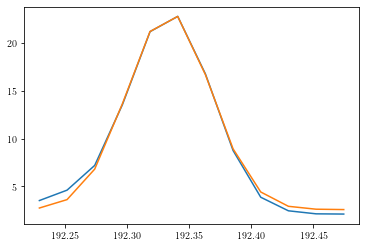

In [118]:
g_init = myGaussian1D(amplitude=10, mean=192.37, stddev = 0.04,bg = 0.)
fit_g = fitting.LevMarLSQFitter()
g_192 = fit_g(g_init, wvl_192, np.mean(data_limb_192,axis=0))
plt.plot(wvl_192, np.mean(data_limb_192,axis=0))
plt.plot(wvl_192, g_192(wvl_192))
g_192.mean

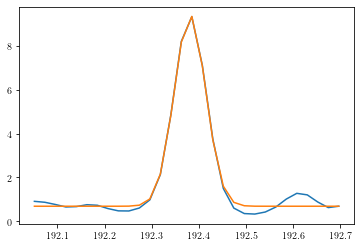

In [120]:
g_init = myGaussian1D(amplitude=10, mean=192.4, stddev = 0.04,bg = 0.)
fit_g = fitting.LevMarLSQFitter()
g_192_stray = fit_g(g_init, data_set_limb["wvl"][1150:1180], data_stray[1150:1180])
plt.plot(data_set_limb["wvl"][1150:1180], data_stray[1150:1180])
plt.plot(data_set_limb["wvl"][1150:1180], g_192_stray(data_set_limb["wvl"][1150:1180]))
g_192_stray.mean = 192.334

Parameter('mean', value=193.4487483055006)

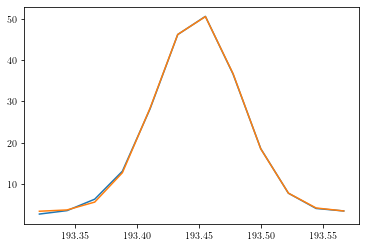

In [116]:
g_init = myGaussian1D(amplitude=20, mean=193.45, stddev = 0.04,bg = 0.)
fit_g = fitting.LevMarLSQFitter()
g_193 = fit_g(g_init, wvl_193, np.mean(data_limb_193,axis=0))
plt.plot(wvl_193, np.mean(data_limb_193,axis=0))
plt.plot(wvl_193, g_193(wvl_193))
g_193.mean

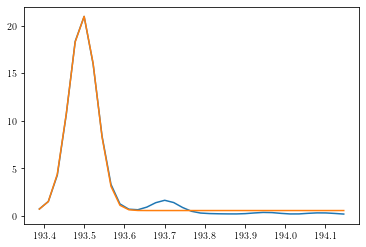

In [117]:
g_init = myGaussian1D(amplitude=20, mean=193.45, stddev = 0.04,bg = 0.)
fit_g = fitting.LevMarLSQFitter()
g_193_stray = fit_g(g_init, data_set_limb["wvl"][1200:1235], data_stray[1200:1235])
plt.plot(data_set_limb["wvl"][1210:1245], data_stray[1210:1245])
plt.plot(data_set_limb["wvl"][1210:1245], g_193_stray(data_set_limb["wvl"][1210:1245]))
g_193_stray.mean = 193.449

Parameter('mean', value=195.05972621912014)

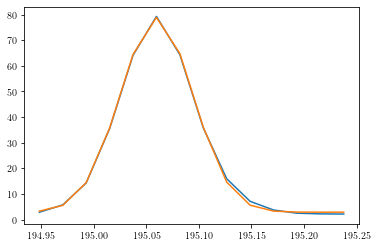

In [121]:
g_init = myGaussian1D(amplitude=30, mean=195.1, stddev = 0.04,bg = 0.)
fit_g = fitting.LevMarLSQFitter()
g_195 = fit_g(g_init, wvl_195, np.mean(data_limb_195,axis=0))
plt.plot(wvl_195, np.mean(data_limb_195,axis=0))
plt.plot(wvl_195, g_195(wvl_195))
g_195.mean

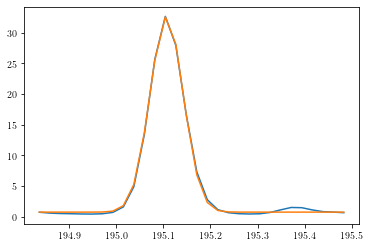

In [124]:
g_init = myGaussian1D(amplitude=20, mean=195.1, stddev = 0.04,bg = 0.)
fit_g = fitting.LevMarLSQFitter()
g_195_stray = fit_g(g_init, data_set_limb["wvl"][1275:1305], data_stray[1275:1305])
plt.plot(data_set_limb["wvl"][1275:1305], data_stray[1275:1305])
plt.plot(data_set_limb["wvl"][1275:1305], g_195_stray(data_set_limb["wvl"][1275:1305]))
g_195_stray.mean = 195.060

In [125]:
data_192_aver = avg(data_limb_192 - g_192_stray(wvl_192),N=16)
data_193_aver = avg(data_limb_193 - g_193_stray(wvl_193),N=16)
data_195_aver = avg(data_limb_195 - g_195_stray(wvl_195),N=16)

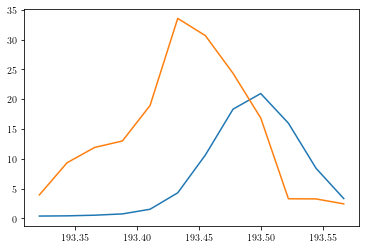

In [139]:
plt.plot(wvl_193, data_stray[1200:1235][7:19])
#plt.plot(wvl_193, data_limb_cor[-300,1200:1235][7:19])
plt.plot(wvl_193, data_limb_193[-300])

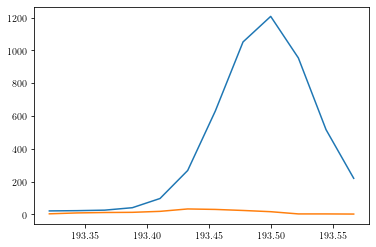

In [92]:
plt.plot(wvl_193,data_disk_cor[400,1200:1235][7:19])
plt.plot(data_set_limb["wvl"][835:850], data_limb_cor[-300,835:850])

/Users/yjzhu/Desktop/Solar/EIS_2019/ipy/fitting_template.py:68: RuntimeWarning: invalid value encountered in sqrt
  g = fit_g(g_init, self.wvl, self.data[ii,:],weights=1/(np.sqrt(self.data[ii,:]*600.0)/600.0))


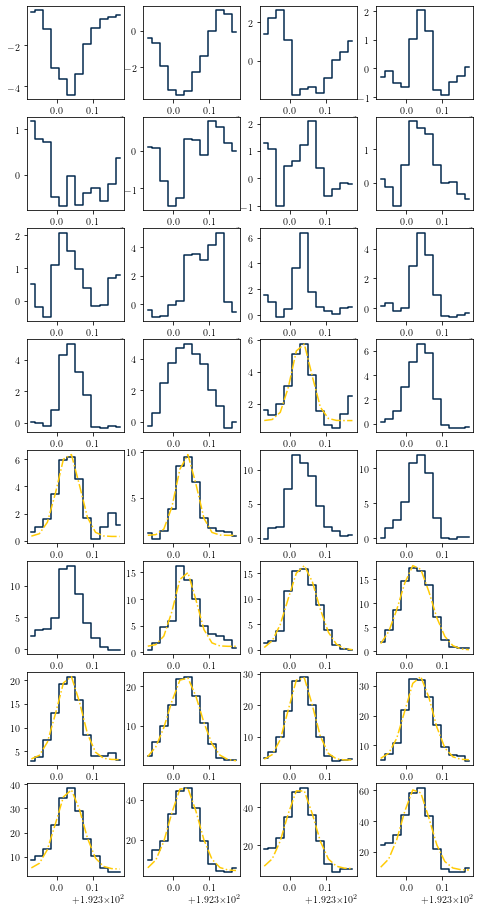

In [126]:
FeXII_192 = FeXII_fit(data_192_aver,wvl_192,[1,192.37,0.04,0.])
FeXII_192.run_lsq()
FeXII_192.plot()

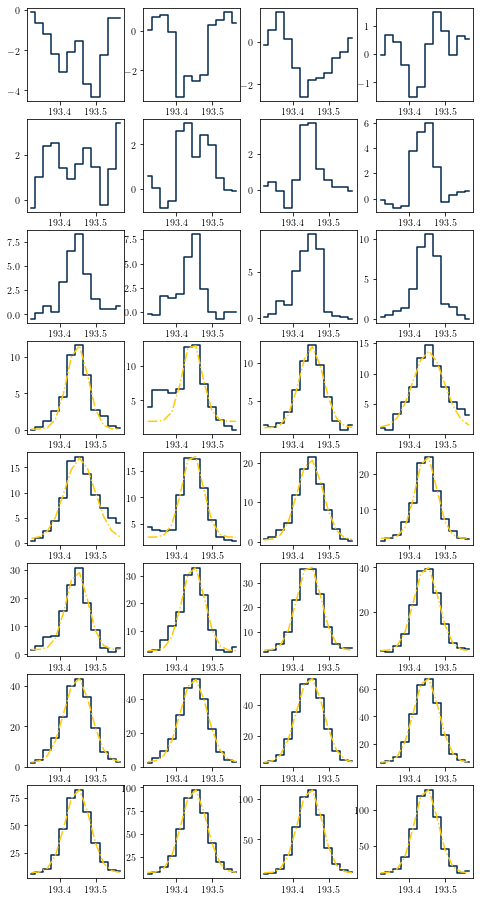

In [128]:
FeXII_193 = FeXII_fit(data_193_aver,wvl_193,[1,193.45,0.04,0.5])
FeXII_193.run_lsq()
FeXII_193.plot()

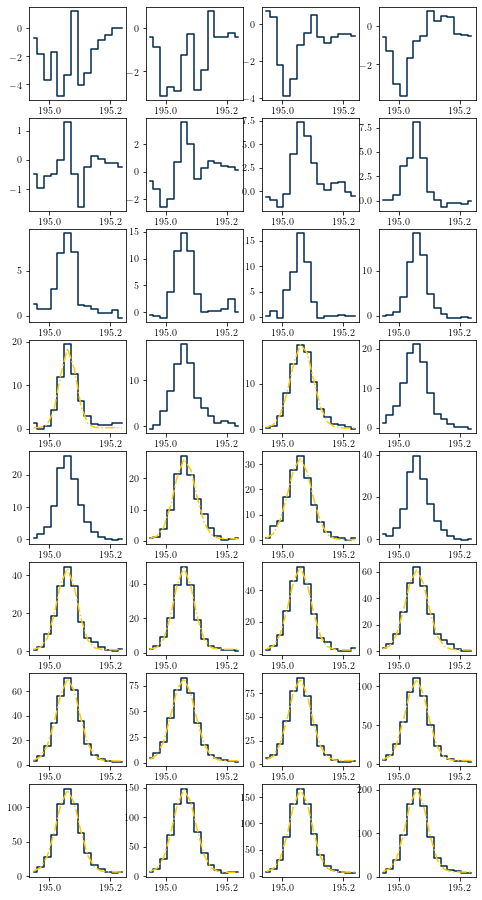

In [129]:
FeXII_195 = FeXII_fit(data_195_aver,wvl_195,[1,195.05,0.04,0.5])
FeXII_195.run_lsq()
FeXII_195.plot()

In [130]:
slit_width = np.array([0.0675426,0.0671961,0.0668643,0.0665481,0.0662484,0.0659660,
                       0.0657016,0.0654560,0.0652299,0.0650239,0.0648386,0.0646745,
                       0.0645322,0.0644121,0.0643145,0.0642399,0.0641885,0.0641607,
                       0.0641566,0.0641764,0.0642202,0.0642881,0.0643802,0.0644964,
                       0.0646367,0.0648009,0.0649889,0.0652005,0.0654355,0.0656935,
                       0.0659743,0.0662773])

In [131]:
fwhm_192 = np.array([  p_[2] for p_ in FeXII_192.get_para()])
fwhm_192_cor = np.flip(np.sqrt(np.power(fwhm_192,2) - np.power(slit_width,2)))
fwhm_192_err = np.flip(fwhm_192)/fwhm_192_cor*np.flip(np.array([  p_[2] for p_ in FeXII_192.get_error()]))

fwhm_193 = np.array([  p_[2] for p_ in FeXII_193.get_para()])
fwhm_193_cor = np.flip(np.sqrt(np.power(fwhm_193,2) - np.power(slit_width,2)))
fwhm_193_err = np.flip(fwhm_193)/fwhm_193_cor*np.flip(np.array([  p_[2] for p_ in FeXII_193.get_error()]))

fwhm_195 = np.array([  p_[2] for p_ in FeXII_195.get_para()])
fwhm_195_cor = np.flip(np.sqrt(np.power(fwhm_195,2) - np.power(slit_width,2)))
fwhm_195_err = np.flip(fwhm_195)/fwhm_195_cor*np.flip(np.array([  p_[2] for p_ in FeXII_195.get_error()]))

/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: RuntimeWarning: invalid value encountered in sqrt
  
/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:10: RuntimeWarning: invalid value encountered in sqrt
  # Remove the CWD from sys.path while we load stuff.


In [132]:
%store -r awsom_y
%store -r awsom_192_fwhm
%store -r awsom_192_fwhm_err
%store -r awsom_193_fwhm
%store -r awsom_193_fwhm_err
%store -r awsom_195_fwhm
%store -r awsom_195_fwhm_err
%store -r awsom_202_fwhm
%store -r awsom_202_fwhm_err

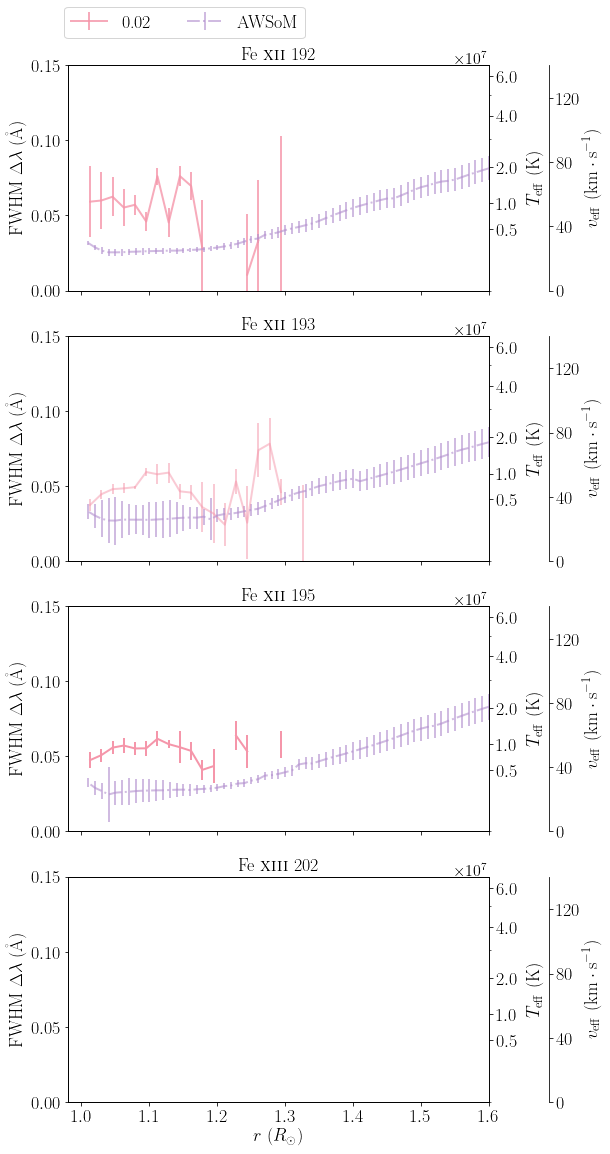

In [135]:
fig, (ax1,ax2,ax3,ax4) = plt.subplots(4,1,figsize=(9,16))

x_start = (3 + 8 - (19+255) + 1242)/966.63
x_end = (514 - 8 - (19+255) + 1242)/966.63
r_coord = np.linspace(x_start,x_end,32)

#for ax_ in (ax1,ax2,ax3,ax4):
#    ax_.plot(r_coord,5*np.power(10,ne_func(r_coord,popt[0],popt[1])/(-4)),color = "#2EA9DF",alpha = 0.5,lw=2)
#    ax_.fill_between(r_coord,1.1*np.power(10,ne_func(r_coord,popt[0] - perr[0],popt[1])/(-4)),
#                     25*np.power(10,ne_func(r_coord,popt[0] + perr[0],popt[1])/(-4)),color = "#7DB9DE",alpha = 0.1)

ln1 = ax1.errorbar(r_coord,fwhm_192_cor,yerr = fwhm_192_err,color = '#F596AA',linewidth=2,alpha=0.8,label='0.02')
#ln2 = ax1.errorbar(r_coord,fwhm_192_cor_bs,yerr = fwhm_192_err_bs,color = '#F9BF45',linewidth=2,ls = '--',alpha=0.8,label='0.04')
#ln3 = ax1.errorbar(r_coord,fwhm_192_cor_bbs,yerr = fwhm_192_err_bbs,color = '#A8D8B9',linewidth=2,ls = '-.',alpha=0.8,label='0.10')
ln4 = ax1.errorbar(-awsom_y[:-1],awsom_192_fwhm[:-1],yerr = awsom_192_fwhm_err[:-1],
                   color = '#B28FCE',linewidth=2,ls = '-.',alpha=0.6,label='AWSoM')

#ax2.plot(r_coord,2*np.power(10,ne_func(r_coord,popt[0],popt[1])/(-4)),color = "#2EA9DF",alpha = 0.5,lw=2)
#ax2.fill_between(r_coord,9*np.power(10,ne_func(r_coord,popt[0] + perr[0],popt[1])/(-4)),
#                 0.44*np.power(10,ne_func(r_coord,popt[0] - perr[0],popt[1])/(-4)),color = "#7DB9DE",alpha = 0.1)

ax2.errorbar(r_coord,fwhm_193_cor,yerr = fwhm_193_err,color = '#F596AA',linewidth=2,alpha=0.5)
#ax2.errorbar(r_coord,fwhm_193_cor_bs,yerr = fwhm_193_err_bs,color = '#F9BF45',linewidth=2,ls = '--',alpha=0.5)
#ax2.errorbar(r_coord,fwhm_193_cor_bbs,yerr = fwhm_193_err_bbs,color = '#A8D8B9',linewidth=2,ls = '-.',alpha=0.5)
ax2.errorbar(-awsom_y[:-1],awsom_193_fwhm[:-1],yerr = awsom_193_fwhm_err[:-1],
                   color = '#B28FCE',linewidth=2,ls = '-.',alpha=0.6,label='AWSoM')

#ax3.plot(r_coord,2*np.power(10,ne_func(r_coord,popt[0],popt[1])/(-4)),color = "#2EA9DF",alpha = 0.5,lw=2)
#ax3.fill_between(r_coord,9*np.power(10,ne_func(r_coord,popt[0] + perr[0],popt[1])/(-4)),
#                 0.44*np.power(10,ne_func(r_coord,popt[0] - perr[0],popt[1])/(-4)),color = "#7DB9DE",alpha = 0.1)

ax3.errorbar(r_coord,fwhm_195_cor,yerr = fwhm_195_err,color = '#F596AA',linewidth=2)
#ax3.errorbar(r_coord,fwhm_195_cor_bs,yerr = fwhm_195_err_bs,color = '#F9BF45',linewidth=2,ls = '--',alpha=0.5)
#ax3.errorbar(r_coord,fwhm_195_cor_bbs,yerr = fwhm_195_err_bbs,color = '#A8D8B9',linewidth=2,ls = '-.',alpha=0.5)
ax3.errorbar(-awsom_y[:-1],awsom_195_fwhm[:-1],yerr = awsom_195_fwhm_err[:-1],
                   color = '#B28FCE',linewidth=2,ls = '-.',alpha=0.6,label='AWSoM')

#ax4.plot(r_coord,2*np.power(10,ne_func(r_coord,popt[0],popt[1])/(-4)),color = "#2EA9DF",alpha = 0.5,lw=2)
#ax4.fill_between(r_coord,9*np.power(10,ne_func(r_coord,popt[0] + perr[0],popt[1])/(-4)),
#                 0.44*np.power(10,ne_func(r_coord,popt[0] - perr[0],popt[1])/(-4)),color = "#7DB9DE",alpha = 0.1)

#ax4.errorbar(r_coord,fwhm_202_cor,yerr = fwhm_202_err,color = '#F596AA',linewidth=2)
#ax4.errorbar(r_coord,fwhm_202_cor_bs,yerr = fwhm_202_err_bs,color = '#F9BF45',linewidth=2,ls = '--',alpha=0.5)
#ax4.errorbar(r_coord,fwhm_202_cor_bbs,yerr = fwhm_202_err_bbs,color = '#A8D8B9',linewidth=2,ls = '-.',alpha=0.5)
#ax4.errorbar(-awsom_y[:-1],awsom_202_fwhm[:-1],yerr = awsom_202_fwhm_err[:-1],
#                   color = '#B28FCE',linewidth=2,ls = '-.',alpha=0.6,label='AWSoM')

ax1.set_title(r"Fe \textsc{xii} 192",fontsize=18)
ax2.set_title(r"Fe \textsc{xii} 193",fontsize=18)
ax3.set_title(r"Fe \textsc{xii} 195",fontsize=18)
ax4.set_title(r"Fe \textsc{xiii} 202",fontsize=18)
ax1.set_xticklabels([])
ax2.set_xticklabels([])
ax3.set_xticklabels([])
for ax_ in (ax1,ax2,ax3,ax4):
    ax_.set_ylim((0,0.15))
    ax_.set_yticks([0.0,0.05,0.10,0.15])
    

ax1_t = ax1.twinx()
ax1_v = ax1.twinx()
ax1_v.spines['right'].set_position(('outward', 60))    

ax2_t = ax2.twinx()
ax2_v = ax2.twinx()
ax2_v.spines['right'].set_position(('outward', 60))  

ax3_t = ax3.twinx()
ax3_v = ax3.twinx()
ax3_v.spines['right'].set_position(('outward', 60))  

ax4_t = ax4.twinx()
ax4_v = ax4.twinx()
ax4_v.spines['right'].set_position(('outward', 60))  


ax1_t_ticks = np.square(np.array([0.,0.05,0.10,0.15])/192.394*c)*56*amu/2/k_B/(4*np.log(2))
ax1_v_ticks = np.array([0.,0.05,0.10,0.15])/192.394*c/np.sqrt(4*np.log(2))/1.e5

def forward(x):
    return x**(1/2)
def inverse(x):
    return x**2

for ax_ in (ax1_t,ax2_t,ax3_t,ax4_t):
    ax_.set_ylim(ax1_t_ticks[0],ax1_t_ticks[-1])
    ax_.set_yscale('function', functions=(forward, inverse))
    #ax_.set_yticklabels(ax1_t_ticks)
    ax_.ticklabel_format(axis="y", style="sci", scilimits=(0,0))
    ax_.yaxis.get_offset_text().set_fontsize(16)
    ax_.set_ylabel(r'$T_{\rm eff}$ (K)',fontsize = 18,labelpad=10)
    ax_.yaxis.set_minor_locator(ticker.MaxNLocator(7))
    ax_.set_yticks([5e6,1e7,2e7,4e7,6e7])

for ax_ in (ax1_v,ax2_v,ax3_v,ax4_v):
    ax_.set_ylim((ax1_v_ticks[0],ax1_v_ticks[-1]))
    ax_.set_ylabel(r'$v_{\rm eff}\ (\mathrm{km\cdot s^{-1}})$',fontsize = 18)
    ax_.yaxis.set_major_locator(ticker.MaxNLocator(4))

for ax_ in (ax1,ax2,ax3,ax1_t,ax1_v,ax2_t,ax2_v,ax3_t,ax3_v,ax4_t,ax4_v):
    #ax_.set_xlabel(r'',fontsize=24)
    #ax_.set_ylabel(r'',fontsize=24)
    ax_.tick_params(labelsize=18)

for ax_ in (ax1,ax2,ax3):
    ax_.set_ylabel(r'FWHM $\Delta \lambda\ (\mathrm{\AA})$',fontsize =18)
ax3.set_xlabel(r'$r\ (R_\odot)$',fontsize=18)


leg = [ln1,ln4]
ax1.legend(leg,[leg_.get_label() for leg_ in leg],bbox_to_anchor=(-0.03,1.1,1,0.2), loc="upper left",fontsize = 18,ncol=4)

for ax_ in (ax1,ax2,ax3,ax4):
    ax_.set_xlabel(r'',fontsize=18)
    ax_.set_ylabel(r'FWHM $\Delta \lambda\ (\mathrm{\AA})$',fontsize =18)
    ax_.tick_params(labelsize=18)
    ax_.set_xlim(0.98,1.6)
ax4.set_xlabel(r'$r\ (R_\odot)$',fontsize=18)
plt.subplots_adjust(bottom = 0.05,left=0.15,top=0.95,right=0.8)
plt.savefig(fname = '../figs/eis_awsom_lvl1.png', dpi = 300, format = 'png')
#plt.savefig(fname = '../figs/eis_awsom.pdf', dpi = 300, format = 'pdf')

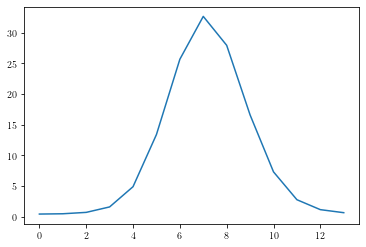

In [47]:
plt.plot(data_stray[1275:1305][5:19])

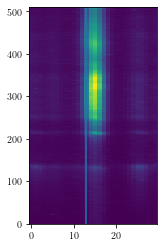

In [143]:
plt.imshow(data_disk_cor[:,1150:1180],origin="lower",aspect=0.1)
plt.axvline(13)

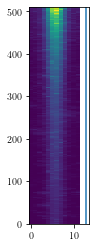

In [69]:
plt.imshow(data_limb_cor[:,1200:1235][:,7:19],origin="lower",aspect=0.1)
plt.axvline(13)

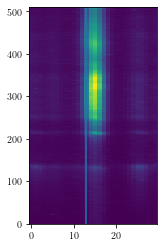

In [19]:
plt.imshow(data_disk_cor[:,1150:1180],origin="lower",aspect=0.1)
plt.axvline(13)

In [16]:
print(data_set_limb["wvl"])

[166.40343086 166.42574765 166.44806441 ... 291.40296773 291.42519089
 291.44741402]


/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: RuntimeWarning: divide by zero encountered in log10
  """Entry point for launching an IPython kernel.


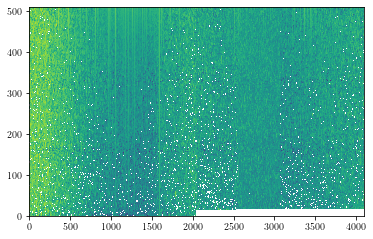

In [14]:
plt.imshow(np.log10(data_limb_cor[:,:]),origin="lower",aspect=5)

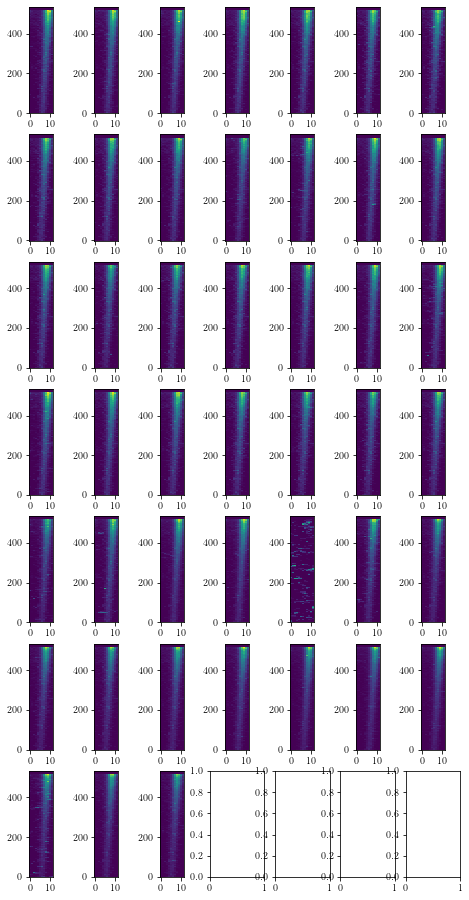

In [110]:
fig, ax = plt.subplots(7,7,figsize=(8,16))
for ii, ax_ in enumerate(ax.flatten()):
    if ii < 45:
        ax_.imshow(data_limb[ii,:,1200:1235][:,7:19],origin="lower",aspect=0.1)